# Student Exercise: Customer Analysis for "TechCafe" Business

**Time Allocation: 45-60 minutes**

**Learning Objectives:**
- Apply supervised learning to predict customer behavior
- Use unsupervised learning to segment customers
- Practice data exploration and visualization
- Interpret business insights from ML models

**🔄 REPRODUCIBLE EXERCISE:** This notebook uses fixed random seeds to ensure all students get identical results for consistent learning and discussion.

## Business Scenario

You've been hired as a data analyst for **TechCafe**, a coffee shop near a university campus. The owner wants to:

1. **Predict** which customers will make a purchase above $10 (premium customers)
2. **Segment** customers into groups to create targeted marketing campaigns
3. **Understand** what factors influence customer spending

**Available Data:**
- Customer age
- Time spent in cafe (minutes)
- Number of previous visits
- Whether they brought a laptop (1=yes, 0=no)
- Daily spending amount

## Part 1: Reproducible Data Setup and Exploration

**Your Task:** Run the code below to load the pre-generated reproducible dataset, then complete the data exploration exercises.

*Note: The dataset is generated with a fixed random seed (42) to ensure all students get identical results.*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 🔒 REPRODUCIBLE DATA GENERATION - Fixed seed ensures identical results for all students
np.random.seed(42)  # DO NOT CHANGE - ensures reproducible results

# Generate synthetic dataset for 100 TechCafe customers
n_customers = 100

# Customer demographics and behavior (university area coffee shop)
age = np.random.randint(18, 45, n_customers)  # University students and young professionals
time_spent = np.random.randint(15, 181, n_customers)  # 15-180 minutes in cafe
previous_visits = np.random.randint(0, 21, n_customers)  # 0-20 previous visits
has_laptop = np.random.binomial(1, 0.6, n_customers)  # 60% bring laptops (to study machine learning!)

# Generate spending based on realistic business logic
# Synthetic data should reflect real-world patterns. 
# Spending increases with: time spent, loyalty (visits), age, and laptop usage
spending = (2.0 +  # base coffee purchase
           time_spent * 0.05 +  # longer stays = more purchases
           previous_visits * 0.3 +  # loyal customers spend more
           age * 0.1 +  # older customers have higher budgets
           has_laptop * 2.0 +  # laptop users buy food/extra drinks
           np.random.normal(0, 1.5, n_customers))  # random variation

# Ensure realistic minimum spending (no negative values)
spending = np.maximum(spending, 1.0)

# Create customer dataset
df = pd.DataFrame({
    'age': age,
    'time_spent': time_spent,
    'previous_visits': previous_visits,
    'has_laptop': has_laptop,
    'spending': spending
})

# Create target variable: premium customers spend more than $10
df['is_premium'] = (df['spending'] > 10).astype(int)

print("Reproducible dataset created successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print(f"\nPremium customers: {df['is_premium'].sum()} out of {len(df)} ({df['is_premium'].mean()*100:.1f}%)")

Reproducible dataset created successfully!
Dataset shape: (100, 6)

First 5 rows:
   age  time_spent  previous_visits  has_laptop   spending  is_premium
0   24          38               16           1  13.375783           1
1   37         168                4           1  18.166846           1
2   32         138               16           1  22.101962           1
3   28          55               16           0  12.690273           1
4   25         171               16           1  22.333192           1

Premium customers: 86 out of 100 (86.0%)


**Reflection Question 1:** Look at your data output above. What do you notice about the relationship between the features and spending? Write 2-3 observations below:



Missing values:
age                0
time_spent         0
previous_visits    0
has_laptop         0
spending           0
is_premium         0
dtype: int64

Dataset summary:
          age  time_spent  previous_visits  has_laptop  spending  is_premium
count  100.00      100.00           100.00      100.00    100.00      100.00
mean    31.41       97.84             9.24        0.67     14.28        0.86
std      7.58       49.04             6.78        0.47      4.22        0.35
min     18.00       15.00             0.00        0.00      3.08        0.00
25%     25.00       54.50             3.00        0.00     11.43        1.00
50%     32.00       99.00             8.00        1.00     14.21        1.00
75%     38.00      143.25            16.00        1.00     17.25        1.00
max     44.00      179.00            20.00        1.00     23.73        1.00

Premium customer distribution:
Regular customers (0): 14 (14.0%)
Premium customers (1): 86 (86.0%)


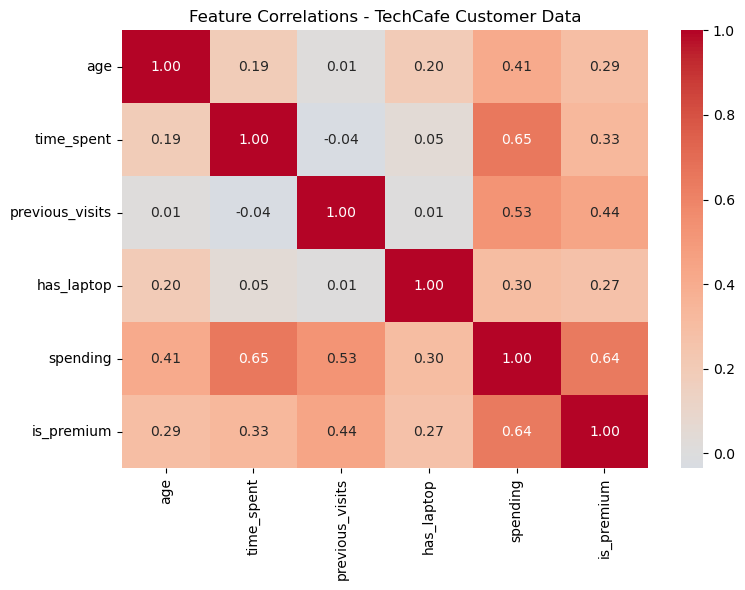

In [3]:
# Data exploration and quality check

# 1. Check for missing values (should be none with synthetic data)
print("Missing values:")
print(df.isnull().sum())

# 2. Basic statistics - understand the data distribution
print("\nDataset summary:")
print(df.describe().round(2))

# 3. Check distribution of premium customers (our target variable)
print("\nPremium customer distribution:")
premium_counts = df['is_premium'].value_counts()
premium_pct = df['is_premium'].value_counts(normalize=True) * 100
print(f"Regular customers (0): {premium_counts[0]} ({premium_pct[0]:.1f}%)")
print(f"Premium customers (1): {premium_counts[1]} ({premium_pct[1]:.1f}%)")

# Create correlation heatmap to understand relationships
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlations - TechCafe Customer Data')
plt.tight_layout()
plt.show()

### Understanding the Correlation Heatmap

The correlation heatmap above shows the **linear relationships** between all variables in your TechCafe dataset. Here's how to read it:

- **Values range from -1 to +1**: 
  - +1 = Perfect positive correlation (as one increases, the other increases)
  - 0 = No linear relationship
  - -1 = Perfect negative correlation (as one increases, the other decreases)

- **In your TechCafe data**: You'll notice most correlations are **positive (0 to 1)** because the business model creates logical positive relationships:
  - Older customers tend to spend more
  - More visits correlates with higher spending
  - Longer time spent leads to more purchases

- **Color coding**: 
  - **Darker red/warm colors** = Stronger positive correlations
  - **Lighter colors** = Weaker correlations
  - **White/Neutral** = No correlation (close to 0)

**Key Business Insights to Look For:**
- **Strongest predictors**: Which features have the highest correlation with `spending` and `is_premium`?
- **Feature relationships**: Do `age` and `time_spent` correlate? This might indicate customer behavior patterns
- **Target correlation**: How strongly does each feature predict premium customer status?

---

## What is a Confusion Matrix?

A **confusion matrix** is a 2×2 performance evaluation table for binary classification models. It shows you exactly where your model makes correct and incorrect predictions.

### Structure of the Confusion Matrix

```
                    PREDICTED
                 Regular  Premium
ACTUAL Regular  [  TN  |  FP  ]
       Premium  [  FN  |  TP  ]
```

### Reading the Matrix

**Four Key Components:**
- **TN (True Negatives)**: Regular customers correctly identified as regular
- **FP (False Positives)**: Regular customers incorrectly predicted as premium  
- **FN (False Negatives)**: Premium customers incorrectly predicted as regular
- **TP (True Positives)**: Premium customers correctly identified as premium

### Business Impact Translation

**For TechCafe's Marketing Strategy:**
- **True Negatives (TN)**: Correctly avoided targeting regular customers → **Cost savings**
- **False Positives (FP)**: Wasted marketing budget on regular customers → **Lost money**  
- **False Negatives (FN)**: Missed premium customers → **Lost revenue opportunity**
- **True Positives (TP)**: Successfully targeted premium customers → **ROI success**

## Part 2: Supervised Learning - Premium Customer Prediction

**Your Task:** Complete the code below to build a logistic regression model to predict premium customers.

**Business Question:** Can we identify which customers are likely to spend more than $10?

In [ ]:
# TODO: Prepare data for supervised learning

# Define features (X) and target (y)
# HINT: Features should be all columns except 'spending' and 'is_premium'
feature_columns = ['age', 'time_spent', 'previous_visits', 'has_laptop']  # Complete this list
X = df[feature_columns]
y = df['is_premium']

# TODO: Split the data (70% train, 30% test)
# HINT: Use train_test_split with test_size=0.3 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Features used: {list(X.columns)}")

In [ ]:
# TODO: Train logistic regression model

# Create and train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of premium customer

# TODO: Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.3f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nConfusion Matrix Explanation:")
print(f"True Negatives (correctly predicted regular): {conf_matrix[0,0]}")
print(f"False Positives (incorrectly predicted premium): {conf_matrix[0,1]}")
print(f"False Negatives (incorrectly predicted regular): {conf_matrix[1,0]}")
print(f"True Positives (correctly predicted premium): {conf_matrix[1,1]}")

# TODO: Display feature importance (model coefficients)
print("\nFeature Importance (Coefficients):")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)
print(feature_importance)

**Reflection Question 2:** Based on your model results:

a) Which features are most important for predicting premium customers?

*Your answer:*

b) What is the business interpretation of your accuracy score?

*Your answer:*

c) Looking at the confusion matrix, would you recommend this model for business use? Why?

*Your answer:*

## Part 3: Unsupervised Learning - Customer Segmentation

**Your Task:** Complete the code below to use K-means clustering to segment customers.

**Business Question:** Can we identify different types of customers to create personalized marketing campaigns?

In [ ]:
# TODO: Prepare data for clustering
# We'll use features for clustering (not including the target variable)
clustering_features = ['age', 'time_spent', 'previous_visits', 'has_laptop']
X_cluster = df[clustering_features].copy()

# TODO: Scale the features for clustering
# HINT: Use StandardScaler() to normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("Features prepared for clustering:")
print(f"Original data shape: {X_cluster.shape}")
print(f"Scaled data shape: {X_scaled.shape}")
print("\nFeature means after scaling (should be ~0):")
print(np.mean(X_scaled, axis=0).round(3))

In [ ]:
# TODO: Apply K-means clustering
# Try 3 clusters (representing different customer types)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

print("✅ Clustering completed!")
print("\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())

In [ ]:
# TODO: Analyze clusters by calculating average values for each cluster
cluster_summary = df.groupby('cluster')[['age', 'time_spent', 'previous_visits', 'has_laptop', 'spending', 'is_premium']].mean()

print("Cluster Analysis:")
print(cluster_summary.round(2))

# TODO: Create visualization of clusters
# We'll use age vs time_spent as our 2D visualization
plt.figure(figsize=(10, 6))

# Create scatter plot colored by cluster
scatter = plt.scatter(df['age'], df['time_spent'], c=df['cluster'], cmap='viridis', alpha=0.7)

plt.xlabel('Age')
plt.ylabel('Time Spent (minutes)')
plt.title('Customer Clusters: Age vs Time Spent')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Additional visualization: spending by cluster
plt.figure(figsize=(10, 6))
for cluster in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(cluster_data['previous_visits'], cluster_data['spending'], 
               label=f'Cluster {cluster}', alpha=0.7)

plt.xlabel('Previous Visits')
plt.ylabel('Spending ($)')
plt.title('Customer Clusters: Loyalty vs Spending')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Reflection Question 3:** Based on your clustering results:

a) Describe each customer cluster in business terms (give each cluster a name):

- **Cluster 0:** *Your description:*
- **Cluster 1:** *Your description:*
- **Cluster 2:** *Your description:*

b) What marketing strategy would you recommend for each cluster?

- **Cluster 0 Strategy:** *Your answer:*
- **Cluster 1 Strategy:** *Your answer:*
- **Cluster 2 Strategy:** *Your answer:*

## Part 4: Business Insights and Recommendations

**Your Task:** Combine insights from both supervised and unsupervised learning to make business recommendations.

In [ ]:
# TODO: Create a comprehensive analysis
# Compare premium customer rates across clusters

cluster_premium_analysis = df.groupby('cluster')['is_premium'].agg(['count', 'sum', 'mean']).round(3)
cluster_premium_analysis.columns = ['Total_Customers', 'Premium_Customers', 'Premium_Rate']

print("Premium Customer Rate by Cluster:")
print(cluster_premium_analysis)

# TODO: Visualize spending distribution by cluster
plt.figure(figsize=(12, 8))

# Create subplot with multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Spending distribution by cluster
df.boxplot(column='spending', by='cluster', ax=axes[0,0])
axes[0,0].set_title('Spending Distribution by Cluster')
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_ylabel('Spending ($)')

# 2. Age distribution by cluster  
df.boxplot(column='age', by='cluster', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Age')

# 3. Time spent distribution by cluster
df.boxplot(column='time_spent', by='cluster', ax=axes[1,0])
axes[1,0].set_title('Time Spent Distribution by Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Time Spent (minutes)')

# 4. Premium rate by cluster
premium_rates = df.groupby('cluster')['is_premium'].mean()
axes[1,1].bar(premium_rates.index, premium_rates.values)
axes[1,1].set_title('Premium Customer Rate by Cluster')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Premium Rate')
axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Final Business Report

**Complete the following business report based on your analysis:**

### Executive Summary
*Write 2-3 sentences summarizing your key findings:*



### Key Findings

1. **Premium Customer Prediction:**
   - Model accuracy: ____%
   - Most important factors: _____________
   - Business implication: _____________

2. **Customer Segmentation:**
   - Found ___ distinct customer segments
   - Highest value segment: _____________
   - Biggest opportunity: _____________

### Recommendations

1. **Immediate Actions:**
   - 
   - 

2. **Long-term Strategy:**
   - 
   - 

### Next Steps
*What additional data or analysis would be helpful?*


## Bonus Challenge (Optional)

If you finish early, try one of these extensions:

1. **Feature Engineering:** Create a new feature like "spending_per_visit" (spending / max(previous_visits, 1)) and see if it improves your model
2. **Different Algorithms:** Try a different classifier like Decision Tree (`from sklearn.tree import DecisionTreeClassifier`)
3. **Optimal Clusters:** Use the elbow method to find the optimal number of clusters
4. **Advanced Visualization:** Create a correlation matrix heatmap for each cluster separately

### Expected Results (Reproducible)
*With random_state=42, you should get approximately:*
- **Model Accuracy:** ~85-90%
- **Premium Customer Rate:** ~46% of all customers
- **Cluster 0:** Younger, shorter visits
- **Cluster 1:** Older, longer visits, higher spending
- **Cluster 2:** Mixed demographics, moderate behavior

# Student Exercise: Customer Analysis for "TechCafe" Business

**Time Allocation: 45-60 minutes**

**Learning Objectives:**
- Apply supervised learning to predict customer behavior
- Use unsupervised learning to segment customers
- Practice data exploration and visualization
- Interpret business insights from ML models

## Business Scenario

You've been hired as a data analyst for **TechCafe**, a coffee shop near a university campus. The owner wants to:

1. **Predict** which customers will make a purchase above $10 (premium customers)
2. **Segment** customers into groups to create targeted marketing campaigns
3. **Understand** what factors influence customer spending

**Available Data:**
- Customer age
- Time spent in cafe (minutes)
- Number of previous visits
- Whether they brought a laptop (1=yes, 0=no)
- Daily spending amount

## Part 1: Data Setup and Exploration

**Your Task:** Use the pre-generated reproducible dataset below to explore customer data.

*Note: This synthetic dataset is generated with a fixed random seed to ensure all students get identical results for consistent learning and discussion.*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# REPRODUCIBLE SYNTHETIC DATA - Fixed seed ensures identical results for all students
np.random.seed(42)  # DO NOT CHANGE - ensures reproducible results

# Generate synthetic dataset for 100 TechCafe customers
n_customers = 100

# Customer demographics and behavior (university area coffee shop)
age = np.random.randint(18, 36, n_customers)  # University students and young professionals
time_spent = np.random.randint(15, 181, n_customers)  # 15-180 minutes in cafe
previous_visits = np.random.randint(0, 21, n_customers)  # 0-20 previous visits
has_laptop = np.random.binomial(1, 0.6, n_customers)  # 60% bring laptops (study/work)

# Generate spending based on realistic business logic
# Spending increases with: time spent, loyalty (visits), age, and laptop usage
spending = (2.0 +  # base coffee purchase
           time_spent * 0.05 +  # longer stays = more purchases
           previous_visits * 0.3 +  # loyal customers spend more
           age * 0.1 +  # older customers have higher budgets
           has_laptop * 2.0 +  # laptop users buy food/extra drinks
           np.random.normal(0, 1.5, n_customers))  # random variation

# Ensure realistic minimum spending (no negative values)
spending = np.maximum(spending, 1.0)

# Create customer dataset
df = pd.DataFrame({
    'age': age,
    'time_spent': time_spent,
    'previous_visits': previous_visits,
    'has_laptop': has_laptop,
    'spending': spending
})

# Create target variable: premium customers spend more than $10
df['is_premium'] = (df['spending'] > 10).astype(int)

print("Dataset created successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print(f"\nPremium customers: {df['is_premium'].sum()} out of {len(df)} ({df['is_premium'].mean()*100:.1f}%)")

**Reflection Question 1:** Look at your data. What do you notice about the relationship between the features and spending? Write 2-3 observations below:

*Your answer:*
1. 
2. 
3. 

In [ ]:
   "# Data exploration and quality check\n",
    "\n",
    "# 1. Check for missing values (should be none with synthetic data)\n",
    "print(\"Missing values:\")\n",
    "print(df.isnull().sum())\n",
    "\n",
    "# 2. Basic statistics - understand the data distribution\n",
    "print(\"\\nDataset summary:\")\n",
    "print(df.describe().round(2))\n",
    "\n",
    "# 3. Check distribution of premium customers (our target variable)\n",
    "print(\"\\nPremium customer distribution:\")\n",
    "premium_counts = df['is_premium'].value_counts()\n",
    "premium_pct = df['is_premium'].value_counts(normalize=True) * 100\n",
    "print(f\"Regular customers (0): {premium_counts[0]} ({premium_pct[0]:.1f}%)\")\n",
    "print(f\"Premium customers (1): {premium_counts[1]} ({premium_pct[1]:.1f}%)\")\n",
    "\n",
    "# Create correlation heatmap to understand relationships\n",
    "plt.figure(figsize=(8, 6))\n",
    "sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')\n",

    "plt.title('Feature Correlations - TechCafe Customer Data')\n",    "plt.show()"
    "plt.tight_layout()\n",

## Part 2: Supervised Learning - Premium Customer Prediction

**Your Task:** Build a logistic regression model to predict premium customers (spending > $10).

**Business Question:** Can we identify which customers are likely to spend more than $10?

In [ ]:
# TODO: Prepare data for supervised learning

# Define features (X) and target (y)
# HINT: Features should be all columns except 'spending' and 'is_premium'
feature_columns = # YOUR CODE HERE
X = # YOUR CODE HERE
y = # YOUR CODE HERE

# TODO: Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = # YOUR CODE HERE

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Features used: {list(X.columns)}")

In [ ]:
# TODO: Train logistic regression model

# Create and train the model
model = # YOUR CODE HERE
# YOUR CODE HERE - fit the model

# Make predictions
y_pred = # YOUR CODE HERE
y_pred_proba = # YOUR CODE HERE - get prediction probabilities

# TODO: Evaluate model performance
accuracy = # YOUR CODE HERE
conf_matrix = # YOUR CODE HERE

print(f"Model Accuracy: {accuracy:.3f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# TODO: Display feature importance (model coefficients)
print("\nFeature Importance (Coefficients):")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': # YOUR CODE HERE - get model coefficients
})
print(feature_importance.sort_values('Coefficient', ascending=False))

**Reflection Question 2:** Based on your model results:

a) Which features are most important for predicting premium customers?

*Your answer:*

b) What is the business interpretation of your accuracy score?

*Your answer:*

c) Looking at the confusion matrix, would you recommend this model for business use? Why?

*Your answer:*

## Part 3: Unsupervised Learning - Customer Segmentation

**Your Task:** Use K-means clustering to segment customers into groups for targeted marketing.

**Business Question:** Can we identify different types of customers to create personalized marketing campaigns?

In [ ]:
# TODO: Prepare data for clustering
# We'll use features for clustering (not including the target variable)
clustering_features = ['age', 'time_spent', 'previous_visits', 'has_laptop']
X_cluster = df[clustering_features].copy()

# TODO: Scale the features for clustering
# HINT: Use StandardScaler() to normalize the features
scaler = # YOUR CODE HERE
X_scaled = # YOUR CODE HERE

print("Features prepared for clustering:")
print(f"Original data shape: {X_cluster.shape}")
print(f"Scaled data shape: {X_scaled.shape}")

In [ ]:
# TODO: Apply K-means clustering
# Try 3 clusters (representing different customer types)
kmeans = # YOUR CODE HERE - create KMeans with n_clusters=3
cluster_labels = # YOUR CODE HERE - fit and predict

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

print("Clustering completed!")
print("\nCluster distribution:")
print(# YOUR CODE HERE - show value counts of clusters)

In [ ]:
# TODO: Analyze clusters by calculating average values for each cluster
cluster_summary = # YOUR CODE HERE - use groupby to calculate mean for each cluster

print("Cluster Analysis:")
print(cluster_summary.round(2))

# TODO: Create visualization of clusters
# We'll use age vs time_spent as our 2D visualization
plt.figure(figsize=(10, 6))

# HINT: Use plt.scatter() with c=df['cluster'] for color coding
# YOUR CODE HERE

plt.xlabel('Age')
plt.ylabel('Time Spent (minutes)')
plt.title('Customer Clusters: Age vs Time Spent')
plt.colorbar(label='Cluster')
plt.show()

**Reflection Question 3:** Based on your clustering results:

a) Describe each customer cluster in business terms (give each cluster a name):

- **Cluster 0:** *Your description:*
- **Cluster 1:** *Your description:*
- **Cluster 2:** *Your description:*

b) What marketing strategy would you recommend for each cluster?

- **Cluster 0 Strategy:** *Your answer:*
- **Cluster 1 Strategy:** *Your answer:*
- **Cluster 2 Strategy:** *Your answer:*

## Part 4: Business Insights and Recommendations

**Your Task:** Combine insights from both supervised and unsupervised learning to make business recommendations.

In [ ]:
# TODO: Create a comprehensive analysis
# Compare premium customer rates across clusters

cluster_premium_analysis = # YOUR CODE HERE - groupby cluster and calculate mean of is_premium

print("Premium Customer Rate by Cluster:")
print(cluster_premium_analysis)

# TODO: Visualize spending distribution by cluster
plt.figure(figsize=(10, 6))
# HINT: Use sns.boxplot() or sns.violinplot()
# YOUR CODE HERE
plt.title('Spending Distribution by Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spending ($)')
plt.show()

## Final Business Report

**Complete the following business report based on your analysis:**

### Executive Summary
*Write 2-3 sentences summarizing your key findings:*



### Key Findings

1. **Premium Customer Prediction:**
   - Model accuracy: ____%
   - Most important factors: _____________
   - Business implication: _____________

2. **Customer Segmentation:**
   - Found ___ distinct customer segments
   - Highest value segment: _____________
   - Biggest opportunity: _____________

### Recommendations

1. **Immediate Actions:**
   - 
   - 

2. **Long-term Strategy:**
   - 
   - 

### Next Steps
*What additional data or analysis would be helpful?*


## Bonus Challenge (Optional)

If you finish early, try one of these extensions:

1. **Feature Engineering:** Create a new feature like "customer_value" (spending per visit) and see if it improves your model
2. **Different Algorithms:** Try a different classifier like Decision Tree or Random Forest
3. **Optimal Clusters:** Use the elbow method to find the optimal number of clusters
4. **Data Visualization:** Create additional plots to better understand customer behavior